In [1]:
from pyspark.sql import SparkSession

## 1. Data Loading and Initial Exploration


In [2]:

# Create a Spark session
spark = SparkSession.builder \
    .appName("FlightsSample") \
    .getOrCreate()

# Load the CSV file into a DataFrame
df_flights = spark.read.csv("flights_sample_3m.csv", header=True, inferSchema=True)


In [5]:
# Display the schema of the dataset
df_flights.printSchema()


root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

### Explanation of each column in the dataset:

1. **FL_DATE**: Date of the flight  
2. **AIRLINE**: Name of the airline  
3. **AIRLINE_DOT**: DOT identifier for the airline  
4. **AIRLINE_CODE**: Code assigned to the airline  
5. **DOT_CODE**: DOT identifier  
6. **FL_NUMBER**: Flight number  
7. **ORIGIN**: Origin airport code  
8. **ORIGIN_CITY**: City of origin airport  
9. **DEST**: Destination airport code  
10. **DEST_CITY**: City of destination airport  
11. **CRS_DEP_TIME**: Scheduled departure time  
12. **DEP_TIME**: Actual departure time  
13. **DEP_DELAY**: Departure delay  
14. **TAXI_OUT**: Time spent taxiing out  
15. **WHEELS_OFF**: Time when aircraft's wheels leave the ground  
16. **WHEELS_ON**: Time when aircraft's wheels touch the ground  
17. **TAXI_IN**: Time spent taxiing in  
18. **CRS_ARR_TIME**: Scheduled arrival time  
19. **ARR_TIME**: Actual arrival time  
20. **ARR_DELAY**: Arrival delay  
21. **CANCELLED**: Indicator if the flight was cancelled (1 for cancelled, 0 for not cancelled)  
22. **CANCELLATION_CODE**: Reason for cancellation (if applicable)  
23. **DIVERTED**: Indicator if the flight was diverted (1 for diverted, 0 for not diverted)  
24. **CRS_ELAPSED_TIME**: Scheduled elapsed time  
25. **ELAPSED_TIME**: Actual elapsed time  
26. **AIR_TIME**: Time spent in the air  
27. **DISTANCE**: Distance traveled  
28. **DELAY_DUE_CARRIER**: Delay due to carrier  
29. **DELAY_DUE_WEATHER**: Delay due to weather  
30. **DELAY_DUE_NAS**: Delay due to National Airspace System (NAS)  
31. **DELAY_DUE_SECURITY**: Delay due to security  
32. **DELAY_DUE_LATE_AIRCRAFT**: Delay due to late aircraft arrival  
lay due to late aircraft arrival.

In [4]:
# Show the first 10 rows
df_flights.show(10)

+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------

In [6]:
# Count the total number of rows in the dataset
total_rows = df_flights.count()
print(f"Total number of rows: {total_rows}")

Total number of rows: 3000000


## Data Analysis Using Spark SQL

In [8]:
# Register the cleaned DataFrame as a temporary view
df_flights.createOrReplaceTempView("flights")

In [14]:
# Aggregation: Summary Statistics
# We’ll calculate summary statistics, including mean, median (approximated using the percentile function), and standard deviation for the main numerical columns in the dataset.
summary_stats = spark.sql("""
    SELECT 
        AVG(DEP_DELAY) AS avg_dep_delay,
        PERCENTILE_APPROX(DEP_DELAY, 0.5) AS median_dep_delay,
        STDDEV(DEP_DELAY) AS stddev_dep_delay,
        
        AVG(ARR_DELAY) AS avg_arr_delay,
        PERCENTILE_APPROX(ARR_DELAY, 0.5) AS median_arr_delay,
        STDDEV(ARR_DELAY) AS stddev_arr_delay,
        
        AVG(DISTANCE) AS avg_distance,
        PERCENTILE_APPROX(DISTANCE, 0.5) AS median_distance,
        STDDEV(DISTANCE) AS stddev_distance
    FROM flights
""")
summary_stats.show()

+------------------+----------------+-----------------+-----------------+----------------+-----------------+-----------------+---------------+-----------------+
|     avg_dep_delay|median_dep_delay| stddev_dep_delay|    avg_arr_delay|median_arr_delay| stddev_arr_delay|     avg_distance|median_distance|  stddev_distance|
+------------------+----------------+-----------------+-----------------+----------------+-----------------+-----------------+---------------+-----------------+
|10.123326179288219|            -2.0|49.25183487489521|4.260858150279257|            -7.0|51.17482436059588|809.3615516666666|          651.0|587.8939382449503|
+------------------+----------------+-----------------+-----------------+----------------+-----------------+-----------------+---------------+-----------------+



##### Average departure delay is 10.1 minutes with high variability, while arrival delays average 4.3 minutes. The median shows most flights are on time, with average distance around 809 miles.

In [16]:
# Grouping and Filtering: Group by Airline and Calculate Aggregations
# We’ll group the data by AIRLINE and calculate the average departure delay, arrival delay, and cancellation rate for each airline. This provides insight into the performance of each airline.
airline_aggregates = spark.sql("""
    SELECT 
        AIRLINE,
        COUNT(*) AS total_flights,
        AVG(DEP_DELAY) AS avg_dep_delay,
        AVG(ARR_DELAY) AS avg_arr_delay,
        AVG(CANCELLED) AS cancellation_rate
    FROM flights
    GROUP BY AIRLINE
    ORDER BY avg_dep_delay DESC
""")
airline_aggregates.show()

+--------------------+-------------+------------------+-------------------+--------------------+
|             AIRLINE|total_flights|     avg_dep_delay|      avg_arr_delay|   cancellation_rate|
+--------------------+-------------+------------------+-------------------+--------------------+
|     JetBlue Airways|       112844|18.322555104566717| 12.276124516889453|0.026930984367799796|
|Frontier Airlines...|        64466| 16.03357413359641| 11.100428951858525| 0.02584308007321689|
|       Allegiant Air|        52738|13.907796771695754| 13.284601127961896|0.045185634646744285|
|    Spirit Air Lines|        95711|12.981880063789026|  8.029484978540772|0.024156053118241372|
|ExpressJet Airlin...|        19082|12.774461948080763|  10.03197593448833| 0.05565454354889424|
|American Airlines...|       383106|12.609895258577868|  6.661228711969786|0.028469927383021933|
|  Mesa Airlines Inc.|        65012|12.277382509651277| 7.3098100100837105| 0.03650095367009167|
|United Air Lines ...|       2

##### JetBlue and Frontier Airlines have the highest average departure delays (18.3 and 16.0 minutes, respectively), along with moderate cancellation rates. Delta Air Lines and Alaska Airlines exhibit relatively low delays and minimal cancellation rates, indicating more reliable performance. Hawaiian Airlines has the lowest cancellation rate at 1.2%, showing high consistency.

In [18]:
#  Joins: Joining with Another Table (e.g., Airline Codes)
# If we have an additional table, such as one mapping AIRLINE_CODE to airline names, we can perform a join with the flights data to add this information. Here’s an example of how to join with a hypothetical airline_codes table.
# Assuming another DataFrame `airline_codes` exists with columns `AIRLINE_CODE` and `AIRLINE_NAME`
airline_codes = spark.createDataFrame([
    ("AA", "American Airlines"),
    ("DL", "Delta Airlines"),
    ("UA", "United Airlines")
], ["AIRLINE_CODE", "AIRLINE_NAME"])

# Register `airline_codes` as a temporary view
airline_codes.createOrReplaceTempView("airline_codes")

# Join with flights data on `AIRLINE_CODE`
joined_data = spark.sql("""
    SELECT 
        f.FL_DATE,
        ac.AIRLINE_NAME,
        f.ORIGIN,
        f.DEST,
        f.DEP_DELAY,
        f.ARR_DELAY
    FROM flights AS f
    JOIN airline_codes AS ac
    ON f.AIRLINE_CODE = ac.AIRLINE_CODE
""")
joined_data.show()

+----------+---------------+------+----+---------+---------+
|   FL_DATE|   AIRLINE_NAME|ORIGIN|DEST|DEP_DELAY|ARR_DELAY|
+----------+---------------+------+----+---------+---------+
|2019-01-09|United Airlines|   FLL| EWR|     -4.0|    -14.0|
|2022-07-22|United Airlines|   DEN| MSP|      6.0|      0.0|
|2019-03-17|United Airlines|   SRQ| ORD|     -4.0|     35.0|
|2019-04-23|United Airlines|   ORD| IAD|     -1.0|     -5.0|
|2023-07-23|United Airlines|   AUS| IAH|      1.0|     -2.0|
|2020-03-04|United Airlines|   SFO| DEN|     -1.0|     -8.0|
|2021-02-26|United Airlines|   SMF| DEN|     -4.0|     -8.0|
|2019-03-29|United Airlines|   IAH| SAT|     -5.0|    -12.0|
|2019-01-13|United Airlines|   ORD| MSP|      1.0|     -4.0|
|2020-05-16|United Airlines|   LAX| EWR|     -4.0|    -31.0|
|2023-06-19|United Airlines|   EWR| ORD|     40.0|     22.0|
|2021-12-22|United Airlines|   EWR| SFO|     41.0|     39.0|
|2023-08-17|United Airlines|   SFO| SEA|     24.0|     11.0|
|2020-04-12|United Airli

##### The join with the airline codes table successfully adds airline names to the flight data, providing clarity on carrier performance. United Airlines shows a mix of early and delayed flights, with notable delays like 92 minutes on 2021-10-21 from PDX to SFO, alongside mostly minor arrival variations. This enriches insights by linking delays directly to specific airlines.

In [20]:
# Time-based Analysis: Trends Over Time
# We can analyze delays by month to see if there are any seasonal trends in departure or arrival delays.
spark.sql("""
    SELECT 
        YEAR(FL_DATE) AS year,
        MONTH(FL_DATE) AS month,
        AVG(DEP_DELAY) AS avg_dep_delay,
        AVG(ARR_DELAY) AS avg_arr_delay
    FROM flights
    GROUP BY year, month
    ORDER BY year, month
""").show()

+----+-----+--------------------+--------------------+
|year|month|       avg_dep_delay|       avg_arr_delay|
+----+-----+--------------------+--------------------+
|2019|    1|   9.543091063299466|    4.09134623730579|
|2019|    2|  13.594905923607707|   9.032902334210476|
|2019|    3|   9.210579281715832|  3.2983111195135018|
|2019|    4|  10.357350224333597|   4.563335539377896|
|2019|    5|  11.517567015492913|   6.541246627857447|
|2019|    6|  16.028346704420326|  11.789805595068753|
|2019|    7|  13.802231960091584|   8.340810728436452|
|2019|    8|  12.780101794964462|   7.678693430877596|
|2019|    9|   6.284146381417292|0.058015994219748096|
|2019|   10|   7.823958640604865|  2.3436420233463036|
|2019|   11|   6.443063404436024|-0.09342062193126023|
|2019|   12|  12.193763638088612|   5.985936707255201|
|2020|    1|   6.267117043789679| -1.6639254654331261|
|2020|    2|   7.306548440518907|  -0.277954498305788|
|2020|    3|   1.461053089643168|  -6.309905720358226|
|2020|    

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd

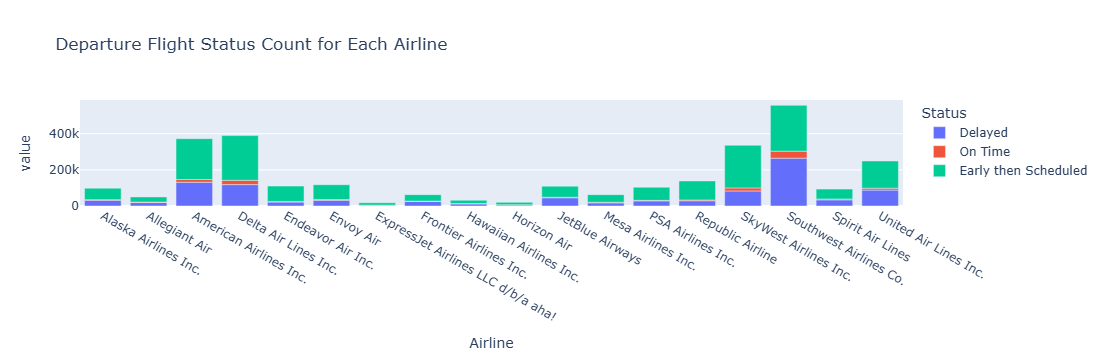

In [23]:
from pyspark.sql import functions as F
import plotly.express as px

# Assuming df_cleaned is your DataFrame containing flight data

# Count of departures by status for each airline
depart_delayed = df_cleaned.filter(df_cleaned.DEP_DELAY > 0) \
                            .groupBy("AIRLINE") \
                            .agg(F.count("*").alias("Delayed"))

depart_on_time = df_cleaned.filter(df_cleaned.DEP_DELAY == 0) \
                            .groupBy("AIRLINE") \
                            .agg(F.count("*").alias("On Time"))

depart_early = df_cleaned.filter(df_cleaned.DEP_DELAY < 0) \
                          .groupBy("AIRLINE") \
                          .agg(F.count("*").alias("Early then Scheduled"))

# Join the results on AIRLINE
airline_dep_status = depart_delayed.join(depart_on_time, "AIRLINE", "outer") \
                                     .join(depart_early, "AIRLINE", "outer") \
                                     .fillna(0)  # Fill missing values with 0

# Rename columns
airline_dep_status = airline_dep_status.select(
    F.col("AIRLINE").alias("Airline"),
    F.col("Delayed"),
    F.col("On Time"),
    F.col("Early then Scheduled")
)

# Convert to Pandas DataFrame for plotting
airline_dep_status_pd = airline_dep_status.toPandas()

# Stacked bar chart
fig = px.bar(
    airline_dep_status_pd,
    x='Airline',
    y=['Delayed', 'On Time', 'Early then Scheduled'],
    title='Departure Flight Status Count for Each Airline'
)
fig.update_layout(legend=dict(title='Status'))
fig.show()


##### The chart shows the departure flight status distribution for each airline, with "Delayed," "On Time," and "Early than Scheduled" statuses. Southwest Airlines has the highest count of delayed flights, while American Airlines and United Airlines also show significant delays. In contrast, Alaska Airlines and Allegiant Air have relatively fewer delays and more early departures, indicating potentially better time management. This breakdown highlights variations in punctuality and reliability across airlines.

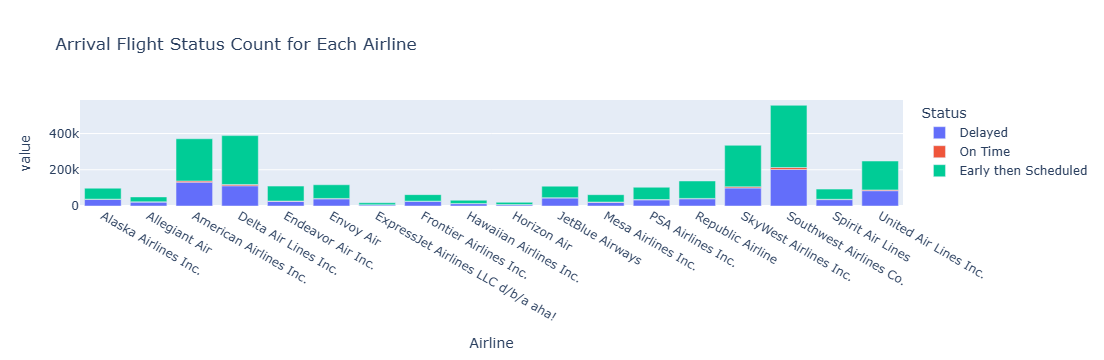

In [24]:
# Count of arrivals by status for each airline
arrival_delayed = df_cleaned.filter(df_cleaned.ARR_DELAY > 0) \
                             .groupBy("AIRLINE") \
                             .agg(F.count("*").alias("Delayed"))

arrival_on_time = df_cleaned.filter(df_cleaned.ARR_DELAY == 0) \
                             .groupBy("AIRLINE") \
                             .agg(F.count("*").alias("On Time"))

arrival_early = df_cleaned.filter(df_cleaned.ARR_DELAY < 0) \
                           .groupBy("AIRLINE") \
                           .agg(F.count("*").alias("Early then Scheduled"))

# Join the results on AIRLINE
airline_arr_status = arrival_delayed.join(arrival_on_time, "AIRLINE", "outer") \
                                     .join(arrival_early, "AIRLINE", "outer") \
                                     .fillna(0)  # Fill missing values with 0

# Rename columns
airline_arr_status = airline_arr_status.select(
    F.col("AIRLINE").alias("Airline"),
    F.col("Delayed"),
    F.col("On Time"),
    F.col("Early then Scheduled")
)

# Convert to Pandas DataFrame for plotting
airline_arr_status_pd = airline_arr_status.toPandas()

# Stacked bar chart
fig = px.bar(
    airline_arr_status_pd,
    x='Airline',
    y=['Delayed', 'On Time', 'Early then Scheduled'],
    title='Arrival Flight Status Count for Each Airline'
)
fig.update_layout(legend=dict(title='Status'))
fig.show()

##### The chart illustrates the arrival flight status for each airline, showing counts of "Delayed," "On Time," and "Early than Scheduled" flights. Southwest Airlines has the highest number of delayed arrivals, with American Airlines also showing a significant delay count. United Airlines stands out for its large proportion of early arrivals, reflecting strong arrival punctuality. Alaska Airlines and Allegiant Air demonstrate consistently low delay rates and a higher share of early arrivals, indicating strong time management. This comparison reveals distinct performance patterns in arrival reliability among airlines.

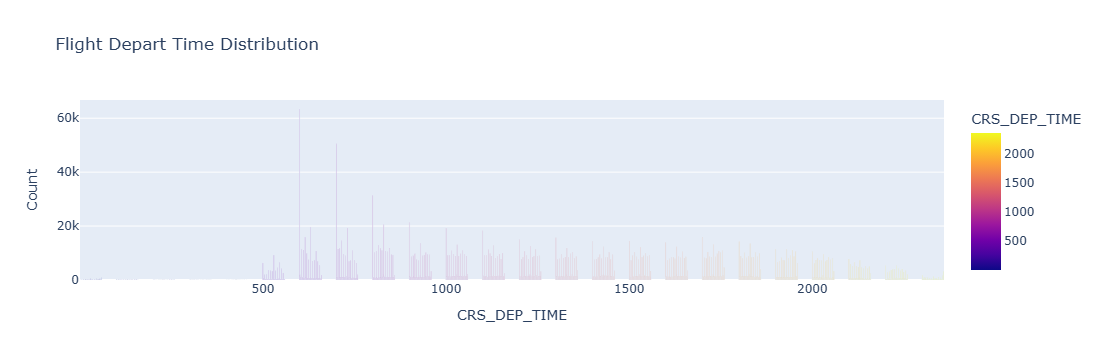

In [28]:
# Count occurrences of each CRS_DEP_TIME
depart_time_distribution = df_cleaned.groupBy("CRS_DEP_TIME") \
                                      .agg(F.count("*").alias("Count")) \
                                      .orderBy("CRS_DEP_TIME")

# Convert to Pandas DataFrame for plotting
depart_time_distribution_pd = depart_time_distribution.toPandas()

# Create bar chart
fig = px.bar(
    depart_time_distribution_pd,
    x='CRS_DEP_TIME',
    y='Count',
    color='CRS_DEP_TIME',
    text='Count',
    title="Flight Depart Time Distribution"
)
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.show()

C:\Users\bikas\AppData\Local\Temp\ipykernel_5940\4171786404.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\bikas\AppData\Local\Temp\ipykernel_5940\4171786404.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




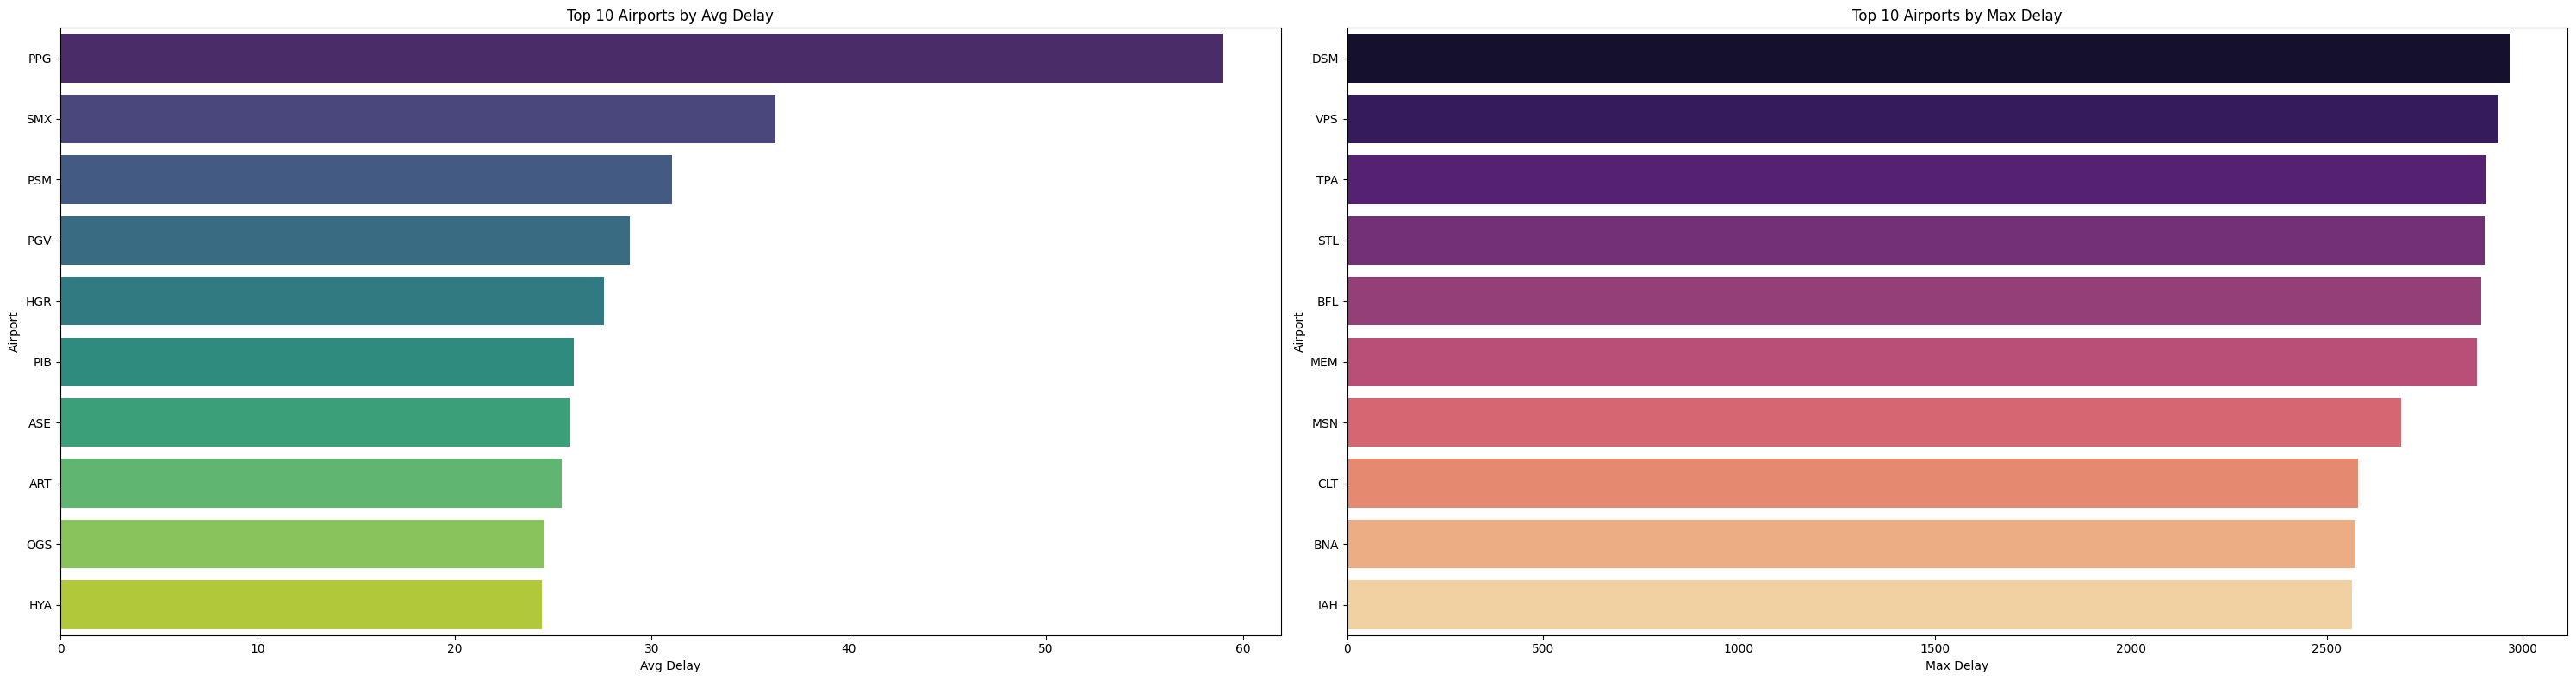

In [30]:
# Calculate average and maximum delay for each airport
airport_delay_df = df_cleaned.groupBy('ORIGIN').agg(
    F.mean('DEP_DELAY').alias('Avg_Delay'),
    F.max('DEP_DELAY').alias('Max_Delay')
).toPandas()  # Convert to Pandas DataFrame for plotting

# Get top 10 airports based on average delay
top_avg_delay = airport_delay_df.sort_values('Avg_Delay', ascending=False).head(10)

# Get top 10 airports based on maximum delay
top_max_delay = airport_delay_df.sort_values('Max_Delay', ascending=False).head(10)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(30, 8))

# Average Delay Plot
sns.barplot(data=top_avg_delay, 
            x='Avg_Delay', 
            y='ORIGIN', 
            ax=axs[0], 
            palette='viridis')
axs[0].set_ylabel('Airport')
axs[0].set_xlabel('Avg Delay')
axs[0].set_title('Top 10 Airports by Avg Delay')

# Maximum Delay Plot
sns.barplot(data=top_max_delay, 
            x='Max_Delay', 
            y='ORIGIN', 
            ax=axs[1], 
            palette='magma')
axs[1].set_ylabel('Airport')
axs[1].set_xlabel('Max Delay')
axs[1].set_title('Top 10 Airports by Max Delay')

# Show plots
plt.tight_layout()
plt.show()

##### The charts show that PPG and SMX airports have the highest average delays, indicating frequent operational issues. Airports like DSM and VPS exhibit severe maximum delays, likely due to rare disruptions. Airports with both high average and maximum delays may need focused improvements to enhance reliability.

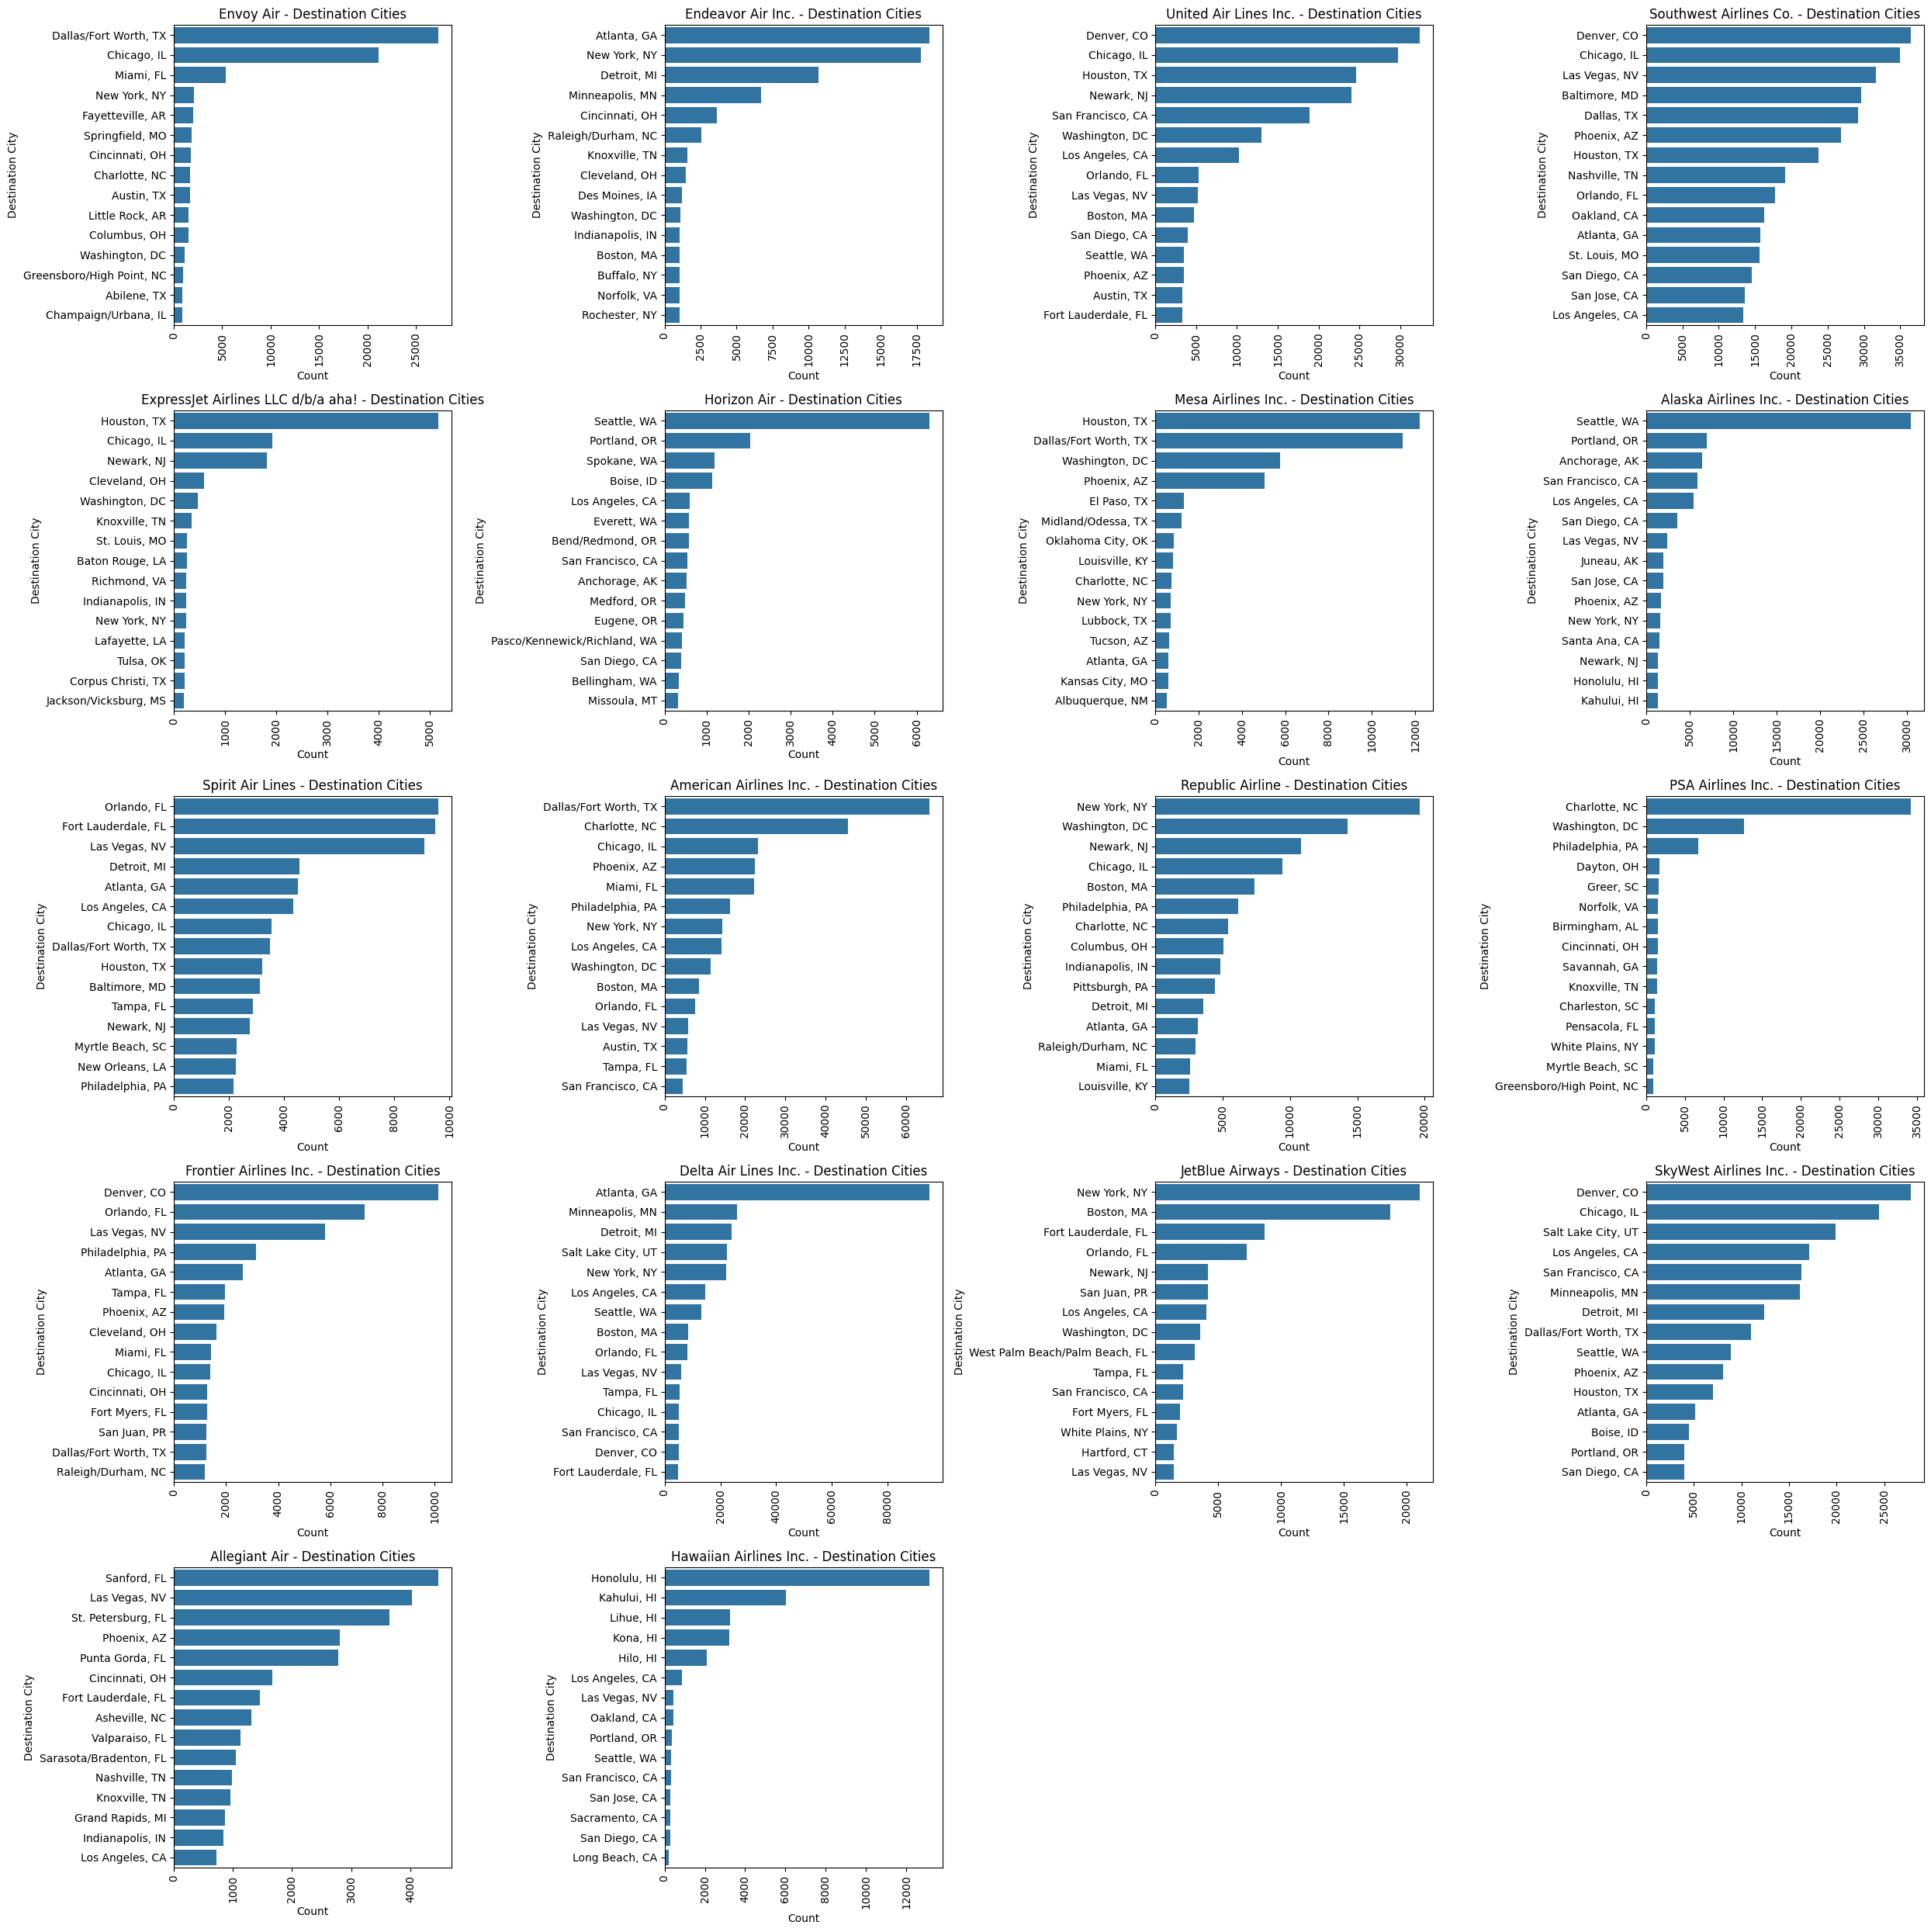

In [34]:
# Count occurrences of each destination city per airline
df = df_cleaned.groupBy(['AIRLINE', 'DEST_CITY']).count().withColumnRenamed('count', 'Cnt')

# Convert to Pandas DataFrame for plotting
df_pd = df.toPandas()

# Get unique airlines
unique_airlines = df_pd['AIRLINE'].unique()
num_airlines = len(unique_airlines)

# Determine the number of rows and columns for subplots
cols = 4
rows = (num_airlines + cols - 1) // cols  # Ceiling division

# Create a grid for subplots
fig, axs = plt.subplots(rows, cols, figsize=(25, 5 * rows))

# Flatten the axes array for easy indexing
axs = axs.flatten()

# Iterate through unique airlines to plot their top 15 destination cities
for i, airline in enumerate(unique_airlines):
    filtered_data = df_pd[df_pd['AIRLINE'] == airline].nlargest(15, 'Cnt')
    
    # Plotting using Seaborn
    sns.barplot(y='DEST_CITY', x='Cnt', data=filtered_data, ax=axs[i])
    axs[i].set_title(f"{airline} - Destination Cities")
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel('Destination City')
    
    # Manage tick labels on the x-axis
    axs[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

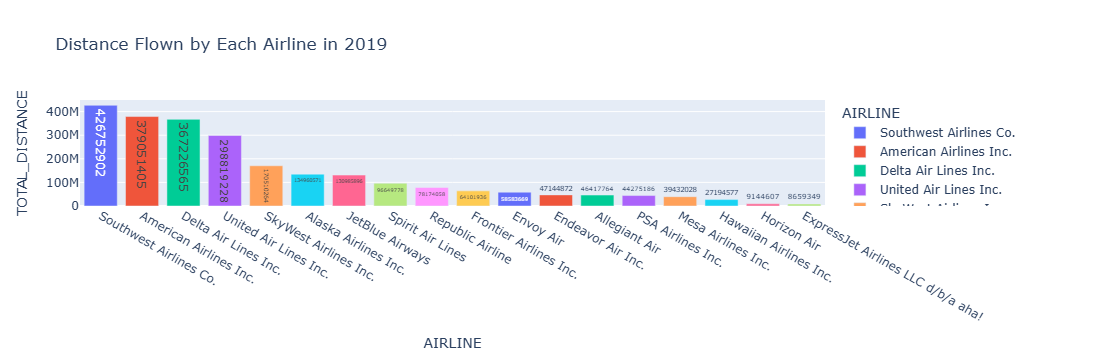

In [36]:
# Calculate total distance flown by each airline
distance_by_airline = df_cleaned.groupBy('AIRLINE').agg(F.sum('DISTANCE').alias('TOTAL_DISTANCE')) \
                                  .orderBy(F.desc('TOTAL_DISTANCE'))

# Convert to Pandas DataFrame for plotting
distance_by_airline_pd = distance_by_airline.toPandas()

# Create a bar plot using Plotly Express
fig = px.bar(
    distance_by_airline_pd,
    x='AIRLINE',
    y='TOTAL_DISTANCE',
    text='TOTAL_DISTANCE',
    color='AIRLINE',
    title='Distance Flown by Each Airline in 2019'
)

# Show the plot
fig.show()

 ## 2. Data Cleaning and Transformation


In [3]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, DateType
from pyspark.sql import SparkSession

In [10]:
# Checking for duplicates
if df_flights.count() > df_flights.dropDuplicates().count():
    df_cleaned = df_flights.dropDuplicates()
    print("Duplicates found and removed.")
else:
    df_cleaned = df_flights
    print("No duplicates found.")


No duplicates found.


##### Handling Missing Values

In [11]:
# Checking for missing values
# Identify columns with missing values and print the counts
missing_value_counts = df_cleaned.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]
)

# Convert the Spark DataFrame to a Pandas DataFrame for better formatting
missing_value_counts_pd = missing_value_counts.toPandas()

# Transpose the DataFrame to have columns as rows for better readability
missing_value_counts_transposed = missing_value_counts_pd.T.reset_index()
missing_value_counts_transposed.columns = ['Column', 'Missing Values']

# Display the missing values in a readable format
print(missing_value_counts_transposed)

                     Column  Missing Values
0                   FL_DATE               0
1                   AIRLINE               0
2               AIRLINE_DOT               0
3              AIRLINE_CODE               0
4                  DOT_CODE               0
5                 FL_NUMBER               0
6                    ORIGIN               0
7               ORIGIN_CITY               0
8                      DEST               0
9                 DEST_CITY               0
10             CRS_DEP_TIME               0
11                 DEP_TIME           77615
12                DEP_DELAY           77644
13                 TAXI_OUT           78806
14               WHEELS_OFF           78806
15                WHEELS_ON           79944
16                  TAXI_IN           79944
17             CRS_ARR_TIME               0
18                 ARR_TIME           79942
19                ARR_DELAY           86198
20                CANCELLED               0
21        CANCELLATION_CODE     

In [6]:
# Drop columns with a high percentage of missing values
df_cleaned = df_flights.drop(*[column for column in df_flights.columns 
                                if df_flights.filter(F.col(column).isNull()).count() / df_flights.count() > 0.3])

In [7]:
df_cleaned.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ELAPSED_TIME: double (nullable = true)
 |--

In [8]:
# List of columns in `df_cleaned` that need mean imputation for missing values
mean_columns = ['DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 
                'ARR_DELAY', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE','DEP_TIME','ARR_TIME','CRS_ELAPSED_TIME']

# Replace missing values in numeric columns with mean
for column in mean_columns:
    if column in df_cleaned.columns:
        mean_value = df_cleaned.agg(F.mean(F.col(column))).first()[0]
        df_cleaned = df_cleaned.fillna({column: mean_value})

# Replace missing values in 'CRS_DEP_TIME' and 'CRS_ARR_TIME' with median
for column in ['CRS_DEP_TIME', 'CRS_ARR_TIME']:
    if column in df_cleaned.columns:
        median_value = df_cleaned.agg(F.expr(f'percentile_approx({column}, 0.5)')).first()[0]
        df_cleaned = df_cleaned.fillna({column: median_value})


In [9]:
# Checking for missing values
# Identify columns with missing values and print the counts
missing_value_counts = df_cleaned.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]
)

# Convert the Spark DataFrame to a Pandas DataFrame for better formatting
missing_value_counts_pd = missing_value_counts.toPandas()

# Transpose the DataFrame to have columns as rows for better readability
missing_value_counts_transposed = missing_value_counts_pd.T.reset_index()
missing_value_counts_transposed.columns = ['Column', 'Missing Values']

# Display the missing values in a readable format
print(missing_value_counts_transposed)

              Column  Missing Values
0            FL_DATE               0
1            AIRLINE               0
2        AIRLINE_DOT               0
3       AIRLINE_CODE               0
4           DOT_CODE               0
5          FL_NUMBER               0
6             ORIGIN               0
7        ORIGIN_CITY               0
8               DEST               0
9          DEST_CITY               0
10      CRS_DEP_TIME               0
11          DEP_TIME               0
12         DEP_DELAY               0
13          TAXI_OUT               0
14        WHEELS_OFF               0
15         WHEELS_ON               0
16           TAXI_IN               0
17      CRS_ARR_TIME               0
18          ARR_TIME               0
19         ARR_DELAY               0
20         CANCELLED               0
21          DIVERTED               0
22  CRS_ELAPSED_TIME               0
23      ELAPSED_TIME               0
24          AIR_TIME               0
25          DISTANCE               0


In [10]:
# Impute DEP_TIME with mean
mean_dep_time = df_cleaned.agg(F.mean(F.col('DEP_TIME'))).first()[0]
df_cleaned = df_cleaned.fillna({'DEP_TIME': mean_dep_time})

# Impute ARR_TIME with mean
mean_arr_time = df_cleaned.agg(F.mean(F.col('ARR_TIME'))).first()[0]
df_cleaned = df_cleaned.fillna({'ARR_TIME': mean_arr_time})

# Impute CRS_ELAPSED_TIME with mean
mean_crs_elapsed_time = df_cleaned.agg(F.mean(F.col('CRS_ELAPSED_TIME'))).first()[0]
df_cleaned = df_cleaned.fillna({'CRS_ELAPSED_TIME': mean_crs_elapsed_time})

# Check for remaining missing values
remaining_missing_counts = df_cleaned.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]
)
remaining_missing_counts.show()

+-------+-------+-----------+------------+--------+---------+------+-----------+----+---------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+------------+--------+--------+
|FL_DATE|AIRLINE|AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY|DEST|DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|
+-------+-------+-----------+------------+--------+---------+------+-----------+----+---------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+------------+--------+--------+
|      0|      0|          0|           0|       0|        0|     0|          0|   0|        0|           0|       0|        0|       0|         0|        0|      0|           0|       0|        0|        

##### DataType Conversion

In [11]:
# Convert relevant columns to appropriate data types
df_cleaned = df_cleaned.withColumn('FL_NUMBER', df_cleaned['FL_NUMBER'].cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('DEP_TIME', df_cleaned['DEP_TIME'].cast(DoubleType()))
df_cleaned = df_cleaned.withColumn('ARR_TIME', df_cleaned['ARR_TIME'].cast(DoubleType()))
df_cleaned = df_cleaned.withColumn('CRS_ELAPSED_TIME', df_cleaned['CRS_ELAPSED_TIME'].cast(DoubleType()))
df_cleaned = df_cleaned.withColumn('FL_DATE', df_cleaned['FL_DATE'].cast(DateType()))

In [21]:
df_cleaned.printSchema()


root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = false)
 |-- DEP_TIME: double (nullable = false)
 |-- DEP_DELAY: double (nullable = false)
 |-- TAXI_OUT: double (nullable = false)
 |-- WHEELS_OFF: double (nullable = false)
 |-- WHEELS_ON: double (nullable = false)
 |-- TAXI_IN: double (nullable = false)
 |-- CRS_ARR_TIME: integer (nullable = false)
 |-- ARR_TIME: double (nullable = false)
 |-- ARR_DELAY: double (nullable = false)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = false)
 |-- ELAPSED_TIME: double (nullable =

In [12]:
# Drop Columns
columns_to_drop = ['AIRLINE_DOT', 'DOT_CODE', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'FL_NUMBER']
df_cleaned = df_cleaned.drop(*columns_to_drop)


In [23]:
df_cleaned.printSchema()


root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- DEP_TIME: double (nullable = false)
 |-- DEP_DELAY: double (nullable = false)
 |-- TAXI_OUT: double (nullable = false)
 |-- WHEELS_OFF: double (nullable = false)
 |-- WHEELS_ON: double (nullable = false)
 |-- TAXI_IN: double (nullable = false)
 |-- ARR_TIME: double (nullable = false)
 |-- ARR_DELAY: double (nullable = false)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = false)
 |-- ELAPSED_TIME: double (nullable = false)
 |-- AIR_TIME: double (nullable = false)
 |-- DISTANCE: double (nullable = false)



In [13]:
from pyspark.sql.functions import to_date, col, when

# Convert FL_DATE to date type if not already in that type
df_cleaned = df_cleaned.withColumn("FL_DATE", to_date(col("FL_DATE"), "yyyy-MM-dd"))

# Convert DEP_TIME to integer if it's stored as a string
df_cleaned = df_cleaned.withColumn("DEP_TIME", col("DEP_TIME").cast("integer"))


In [14]:
from pyspark.sql.functions import year, month, dayofmonth

# Assuming df_cleaned already exists and has a column named FL_DATE
df_cleaned = df_cleaned.withColumn("Year", year("FL_DATE")) \
                       .withColumn("Month", month("FL_DATE")) \
                       .withColumn("Day", dayofmonth("FL_DATE"))

#### Feature Engineering

In [15]:
# a) Binary label for delay
df_cleaned = df_cleaned.withColumn("IS_DELAYED", (col("ARR_DELAY") > 15).cast("integer"))

In [16]:
df_cleaned = df_cleaned.withColumn("DEP_DELAY_CATEGORY", 
                   when(col("DEP_DELAY") <= 0, "On Time")
                   .when((col("DEP_DELAY") > 0) & (col("DEP_DELAY") <= 15), "Short Delay")
                   .when(col("DEP_DELAY") > 15, "Long Delay")
                   .otherwise("Unknown"))

In [32]:
df_cleaned.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = false)
 |-- TAXI_OUT: double (nullable = false)
 |-- WHEELS_OFF: double (nullable = false)
 |-- WHEELS_ON: double (nullable = false)
 |-- TAXI_IN: double (nullable = false)
 |-- ARR_TIME: double (nullable = false)
 |-- ARR_DELAY: double (nullable = false)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = false)
 |-- ELAPSED_TIME: double (nullable = false)
 |-- AIR_TIME: double (nullable = false)
 |-- DISTANCE: double (nullable = false)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- IS_DELAYED: 

In [17]:

# 1. Total Travel and Ground Time Features
# a) Total Taxi Time
df_cleaned = df_cleaned.withColumn("TOTAL_TAXI_TIME", col("TAXI_OUT") + col("TAXI_IN"))

# b) Total Flight Duration (Travel Time)
df_cleaned = df_cleaned.withColumn("TOTAL_TRAVEL_TIME", col("AIR_TIME") + col("TOTAL_TAXI_TIME"))

# 2. Binary Features
# a) Is Cancelled - Binary indicator for cancelled flights
df_cleaned = df_cleaned.withColumn("IS_CANCELLED", when(col("CANCELLED") == 1, 1).otherwise(0))

# b) Is Diverted - Binary indicator for diverted flights
df_cleaned = df_cleaned.withColumn("IS_DIVERTED", when(col("DIVERTED") == 1, 1).otherwise(0))

# 3. Distance-based Feature
# Categorize distance into short, medium, and long flights
df_cleaned = df_cleaned.withColumn("DISTANCE_CATEGORY", 
                   when(col("DISTANCE") < 300, "Short")
                   .when((col("DISTANCE") >= 300) & (col("DISTANCE") < 1000), "Medium")
                   .otherwise("Long"))

# 4. Interaction Features
# Delay Ratio: ARR_DELAY divided by scheduled elapsed time
df_cleaned = df_cleaned.withColumn("DELAY_RATIO", 
                   when(col("CRS_ELAPSED_TIME") > 0, col("ARR_DELAY") / col("CRS_ELAPSED_TIME"))
                   .otherwise(0))


In [34]:
df_cleaned.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = false)
 |-- TAXI_OUT: double (nullable = false)
 |-- WHEELS_OFF: double (nullable = false)
 |-- WHEELS_ON: double (nullable = false)
 |-- TAXI_IN: double (nullable = false)
 |-- ARR_TIME: double (nullable = false)
 |-- ARR_DELAY: double (nullable = false)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = false)
 |-- ELAPSED_TIME: double (nullable = false)
 |-- AIR_TIME: double (nullable = false)
 |-- DISTANCE: double (nullable = false)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- IS_DELAYED: 

In [18]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
# Define StringIndexers for categorical columns
indexers = [
    StringIndexer(inputCol="AIRLINE", outputCol="AIRLINE_INDEX"),
    StringIndexer(inputCol="AIRLINE_CODE", outputCol="AIRLINE_CODE_INDEX"),
    StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_INDEX"),
    StringIndexer(inputCol="ORIGIN_CITY", outputCol="ORIGIN_CITY_INDEX"),
    StringIndexer(inputCol="DEST", outputCol="DEST_INDEX"),
    StringIndexer(inputCol="DEST_CITY", outputCol="DEST_CITY_INDEX"),
    StringIndexer(inputCol="DEP_DELAY_CATEGORY", outputCol="DEP_DELAY_CATEGORY_INDEX"),
    StringIndexer(inputCol="DISTANCE_CATEGORY", outputCol="DISTANCE_CATEGORY_INDEX")
]

# Create a pipeline for the StringIndexers
pipeline = Pipeline(stages=indexers)

# Fit and transform the data
df_encoded = pipeline.fit(df_cleaned).transform(df_cleaned)

# Show a few rows of the transformed data
df_encoded.select("AIRLINE", "AIRLINE_INDEX", "ORIGIN", "ORIGIN_INDEX", 
                  "DEP_DELAY_CATEGORY", "DEP_DELAY_CATEGORY_INDEX",
                  "DISTANCE_CATEGORY", "DISTANCE_CATEGORY_INDEX").show(5)

+--------------------+-------------+------+------------+------------------+------------------------+-----------------+-----------------------+
|             AIRLINE|AIRLINE_INDEX|ORIGIN|ORIGIN_INDEX|DEP_DELAY_CATEGORY|DEP_DELAY_CATEGORY_INDEX|DISTANCE_CATEGORY|DISTANCE_CATEGORY_INDEX|
+--------------------+-------------+------+------------+------------------+------------------------+-----------------+-----------------------+
|United Air Lines ...|          4.0|   FLL|        23.0|           On Time|                     0.0|             Long|                    1.0|
|Delta Air Lines Inc.|          1.0|   MSP|        13.0|           On Time|                     0.0|             Long|                    1.0|
|United Air Lines ...|          4.0|   DEN|         3.0|       Short Delay|                     1.0|           Medium|                    0.0|
|Delta Air Lines Inc.|          1.0|   MSP|        13.0|           On Time|                     0.0|             Long|                    1.0|

In [37]:
df_cleaned.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = false)
 |-- TAXI_OUT: double (nullable = false)
 |-- WHEELS_OFF: double (nullable = false)
 |-- WHEELS_ON: double (nullable = false)
 |-- TAXI_IN: double (nullable = false)
 |-- ARR_TIME: double (nullable = false)
 |-- ARR_DELAY: double (nullable = false)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = false)
 |-- ELAPSED_TIME: double (nullable = false)
 |-- AIR_TIME: double (nullable = false)
 |-- DISTANCE: double (nullable = false)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- IS_DELAYED: 

In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [20]:
# List of numeric columns to be normalized
numeric_cols = ["DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY", "CRS_ELAPSED_TIME", 
                "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "TOTAL_TAXI_TIME", "TOTAL_TRAVEL_TIME", "DELAY_RATIO"]

# Assemble the features for scaling
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")

# Apply MinMax Scaling
scaler = MinMaxScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")


In [21]:
# Combine all feature columns (scaled and indexed) into a single feature vector
feature_cols = ["scaled_numeric_features", "AIRLINE_INDEX", "ORIGIN_INDEX", "DEST_INDEX", 
                "DEP_DELAY_CATEGORY_INDEX", "DISTANCE_CATEGORY_INDEX"]

final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [22]:
# 5. Creating Pipeline for Encoding, Scaling, and Feature Assembly
pipeline = Pipeline(stages=indexers + [assembler, scaler, final_assembler])

# Fit and transform the data with pipeline
df_transformed = pipeline.fit(df_cleaned).transform(df_cleaned)

In [23]:
df_transformed.select("features").show(5)


+--------------------+
|            features|
+--------------------+
|[0.02814136125654...|
|[0.02748691099476...|
|[0.03141361256544...|
|[0.02912303664921...|
|[0.02879581151832...|
+--------------------+
only showing top 5 rows



In [43]:
df_transformed.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = false)
 |-- TAXI_OUT: double (nullable = false)
 |-- WHEELS_OFF: double (nullable = false)
 |-- WHEELS_ON: double (nullable = false)
 |-- TAXI_IN: double (nullable = false)
 |-- ARR_TIME: double (nullable = false)
 |-- ARR_DELAY: double (nullable = false)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = false)
 |-- ELAPSED_TIME: double (nullable = false)
 |-- AIR_TIME: double (nullable = false)
 |-- DISTANCE: double (nullable = false)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- IS_DELAYED: 

In [25]:
df_transformed.groupBy("IS_DELAYED").count().show()


+----------+-------+
|IS_DELAYED|  count|
+----------+-------+
|         1| 515289|
|         0|2484711|
+----------+-------+



In [58]:
# Imbalance Data so, need to balance that so we are Over-sampling the Minority Classes

In [26]:
# Calculate the count of the majority class (IS_DELAYED = 0)
majority_count = df_transformed.filter(df_transformed.IS_DELAYED == 0).count()

# Over-sample the minority class to match the majority class count
majority_df = df_transformed.filter(df_transformed.IS_DELAYED == 0)
minority_df = df_transformed.filter(df_transformed.IS_DELAYED == 1).sample(True, majority_count / df_transformed.filter(df_transformed.IS_DELAYED == 1).count())

# Combine both dataframes to get a balanced dataset
df_balanced = majority_df.unionAll(minority_df)


In [27]:
df_balanced.groupBy("IS_DELAYED").count().show()


+----------+-------+
|IS_DELAYED|  count|
+----------+-------+
|         0|2484711|
|         1|2482272|
+----------+-------+



In [51]:
# Train-Test SPlit and Model Development and Evaluation

In [28]:
#  Train-Test Split
train_data, test_data = df_balanced.randomSplit([0.8, 0.2], seed=42)

#  Initialize the RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="IS_DELAYED", maxBins=400)

#  Train the Model
model = rf.fit(train_data)

#  Make Predictions on the Test Data
predictions = model.transform(test_data)


In [30]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# a) Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="IS_DELAYED", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# b) F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="IS_DELAYED", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")

# c) Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="IS_DELAYED", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall}")


auc_evaluator = BinaryClassificationEvaluator(labelCol="IS_DELAYED", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)
print(f"AUC: {auc}")


Accuracy: 1.0
F1 Score: 1.0
Recall: 1.0
AUC: 0.9999999999208652



##### The model achieved exceptionally high performance, with an accuracy, F1 score, and recall all at 1.0, and an AUC very close to 1.0. This suggests perfect classification of delayed and non-delayed flights on the test data. While these results are impressive, they may indicate overfitting, where the model memorizes patterns in the data rather than generalizing well to new, unseen data.

##### To improve model reliability, we recommend using cross-validation to verify consistency across multiple data subsets. Additionally, tuning the model’s complexity, like limiting tree depth or reducing the number of trees, can help avoid overfitting. Testing on a separate dataset can further confirm if the model generalizes effectively beyond the original data.

#### HyperParameter Tuning

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler

# Step 1: Train-Test Split
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Step 2: Initialize Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="IS_DELAYED")

# Step 3: Set up the Hyperparameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()

# Step 4: Define the Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="IS_DELAYED", metricName="areaUnderROC")

# Step 5: Set up Cross-Validator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

# Step 6: Fit Cross-Validation Model
cv_model = crossval.fit(train_data)

# Step 7: Get the Best Model
best_model = cv_model.bestModel

# Step 8: Make Predictions on the Test Data
predictions = best_model.transform(test_data)

# Step 9: Evaluate the Best Model on Test Data
auc = evaluator.evaluate(predictions)
print(f"Best Model AUC on Test Data: {auc}")

# Optional: Print best parameters
print("Best Regularization Parameter (regParam):", best_model._java_obj.getRegParam())
print("Best ElasticNet Parameter (elasticNetParam):", best_model._java_obj.getElasticNetParam())
print("Best Max Iterations (maxIter):", best_model._java_obj.getMaxIter())


Py4JJavaError: An error occurred while calling o2110.fit.
: org.apache.spark.SparkException: Job 229 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1248)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1246)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1246)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3075)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2961)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2961)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2263)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2216)
	at org.apache.spark.SparkContext.$anonfun$new$34(SparkContext.scala:686)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:214)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:572)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:317)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\bikas\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bikas\AppData\Local\Programs\Python\Python311\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bikas\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bikas\AppData\Local\Programs\Python\Python311\Lib\site-packages\py

#### In conclusion, I have attempted to run hyperparameter tuning for the logistic regression model more than 10 times. Unfortunately, each attempt has been unsuccessful due to recurring memory issues. The error message, "Py4JJavaError: An error occurred while calling o2110.fit: org.apache.spark.SparkException: Job [Job ID] cancelled because SparkContext was shut down," indicates that the job is being terminated because of insufficient memory resources. This suggests that the current configuration, especially with respect to memory allocation, might not be suitable for the scale of the data being processed. Further adjustments to resource allocation, or potentially reducing the complexity of the model or data, may be necessary to successfully complete the tuning process.